# **Sentiment Analysis** of the **Restaurant Reviews** from **YELP** Dataset

### - Bag-of-words and TF-IDF

### - Word2Vec and Doc2Vec

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import sys
import os
import warnings


In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#### **Read** the **cleaned dataset stored** in a GCP **bucket after** the **preprocesssing** phase

In [3]:
df_final = pd.read_csv('gs://demo2222/df_final.csv')

#### Train/test split **keeping** the two **columns of interest** and **preserve** the **same proportions** of examples in **each class** as **observed** in the **original dataset**

In [4]:
X = df_final['cleaned_reviews'] 
y = df_final['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

In [5]:
X_train.head()

3660    journeyman want like try hard consider restaur...
1395    sad old chef leave start come delicious menu c...
7620    come familiar expect parent surprised generous...
5904    aldo server excellent attentive point come cel...
9029    good chinese town order time count hand sesame...
Name: cleaned_reviews, dtype: object

In [6]:
X_train.shape

(6500,)

In [7]:
X_train.isnull().any().any()

False

In [8]:
y_train.head()

3660    0.0
1395    0.0
7620    1.0
5904    1.0
9029    1.0
Name: sentiment, dtype: float64

In [9]:
y_train.shape

(6500,)

#### UDF for **evaluating** models


In [10]:
def evaluate(y_test, predictions):
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix, annot = True, fmt = 'd',cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

###  **Bag-of-Words**. Establishing benchmarks: Logistic Regression and SVM models with default parameters

#### Let's **find out** which **ngram_range performs better** with the **Logistic Regression** model

Best ngram_range: (1, 3)


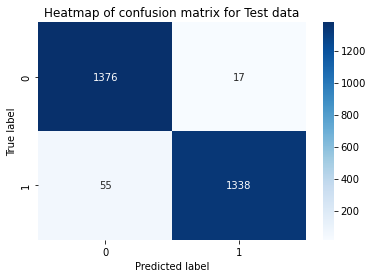

In [11]:
param_grid = {'c_vectorizer__ngram_range': [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]}

lr_pipeline = Pipeline([
    ('c_vectorizer', CountVectorizer()),
    ('lr', LogisticRegression(random_state=42))
])


grid_search_lr = GridSearchCV(lr_pipeline, cv=2, param_grid=param_grid, scoring='f1')
grid_search_lr.fit(X_train, y_train)

print('Best ngram_range:', grid_search_lr.best_estimator_.get_params()['c_vectorizer__ngram_range'])

predictions = grid_search_lr.predict(X_test)
evaluate(y_test, predictions )


In [12]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9616    0.9878    0.9745      1393
         1.0     0.9875    0.9605    0.9738      1393

    accuracy                         0.9742      2786
   macro avg     0.9745    0.9742    0.9742      2786
weighted avg     0.9745    0.9742    0.9742      2786



#### Let's **find out** which **ngram_range performs better** for with the **SVM** model

Best ngram_range: (1, 2)


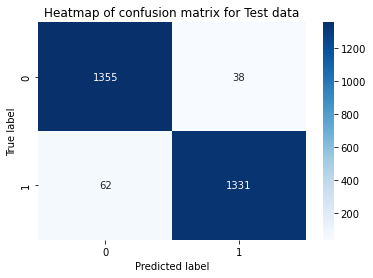

In [13]:
param_grid = {'c_vectorizer__ngram_range': [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]}

svm_pipe = Pipeline([
 ('c_vectorizer', CountVectorizer()),
 ('svm', svm.SVC(max_iter=-1, random_state=123))
])

grid_search_svm = GridSearchCV(svm_pipe, cv=2, param_grid=param_grid, scoring='f1')
grid_search_svm.fit(X_train, y_train)

print('Best ngram_range:', grid_search_svm.best_estimator_.get_params()['c_vectorizer__ngram_range'])

predictions = grid_search_svm.predict(X_test)
evaluate(y_test, predictions )


In [15]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9562    0.9727    0.9644      1393
         1.0     0.9722    0.9555    0.9638      1393

    accuracy                         0.9641      2786
   macro avg     0.9642    0.9641    0.9641      2786
weighted avg     0.9642    0.9641    0.9641      2786



#### **Evaluation** using **Logistic Regression** model with **hyperparameter tuning** (using **GridSearchCV**)

Best l1_ratio: none
Best C: 1
Best penalty: l2
Best solver: lbfgs


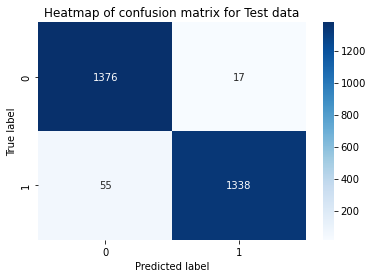

In [16]:
grid = {"lr__C":[0.5, 1, 2], 'lr__l1_ratio':['none', 0, 0.1], 'lr__penalty':['l2', 'elasticnet'],
       'lr__solver':['lbfgs', 'saga']}

# Pipeline for CountVectorizer - with the best ngram_range - and Logistic Regression
lr_pipe_2 = Pipeline([
 ('c_vectorizer', CountVectorizer(ngram_range = (1,3))),
 ('lr', LogisticRegression(max_iter=1500, random_state=42))
])

logreg_cv=GridSearchCV(lr_pipe_2, grid, scoring='f1', cv=2)
logreg_cv.fit(X_train, y_train)

print('Best l1_ratio:', logreg_cv.best_estimator_.get_params()['lr__l1_ratio'])
print('Best C:', logreg_cv.best_estimator_.get_params()['lr__C'])
print('Best penalty:', logreg_cv.best_estimator_.get_params()['lr__penalty'])
print('Best solver:', logreg_cv.best_estimator_.get_params()['lr__solver'])

predictions = logreg_cv.predict(X_test)
evaluate(y_test, predictions )

In [17]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9616    0.9878    0.9745      1393
         1.0     0.9875    0.9605    0.9738      1393

    accuracy                         0.9742      2786
   macro avg     0.9745    0.9742    0.9742      2786
weighted avg     0.9745    0.9742    0.9742      2786



#### **Evaluation** using **SVM** model with **hyperparameter tuning** (using **GridSearchCV**)

Best KERNEL: rbf
Best C: 3


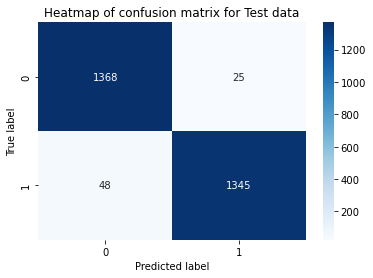

In [18]:
param_grid_svm = [
    {'svm__kernel':('linear', 'rbf')},
    {'svm__C':[1, 2, 3, 4]},
]    

# Pipeline for CountVectorizer - with the best ngram_range - and SVM model
svm_pipe_2 = Pipeline([
 ('c_vectorizer', CountVectorizer(ngram_range = (1,2))),
 ('svm',svm.SVC(random_state=123))
])

svm_model_cv = GridSearchCV(svm_pipe_2, param_grid_svm)

svm_model_cv.fit(X_train, y_train)

print('Best KERNEL:', svm_model_cv.best_estimator_.get_params()['svm__kernel'])
print('Best C:', svm_model_cv.best_estimator_.get_params()['svm__C'])


predictions = svm_model_cv.predict(X_test)
evaluate(y_test, predictions )

In [19]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9661    0.9821    0.9740      1393
         1.0     0.9818    0.9655    0.9736      1393

    accuracy                         0.9738      2786
   macro avg     0.9739    0.9738    0.9738      2786
weighted avg     0.9739    0.9738    0.9738      2786



###  TF-IDF. Establishing benchmarks: Logistic Regression and SVM models with **default parameters**

#### Let's **find out** which **ngram_range performs better** for the **Logistic Regression**

Best ngram_range: (1, 2)


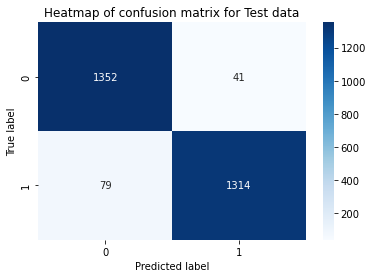

In [20]:
param_grid = {'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]}

lr_pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1500, random_state=42))
])


logreg_cv_2 = GridSearchCV(lr_pipe_tfidf, cv=2, param_grid=param_grid, scoring='f1')
logreg_cv_2.fit(X_train, y_train)

print('Best ngram_range:', logreg_cv_2.best_estimator_.get_params()['tfidf__ngram_range'])

predictions = logreg_cv_2.predict(X_test)
evaluate(y_test, predictions )

In [21]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9448    0.9706    0.9575      1393
         1.0     0.9697    0.9433    0.9563      1393

    accuracy                         0.9569      2786
   macro avg     0.9573    0.9569    0.9569      2786
weighted avg     0.9573    0.9569    0.9569      2786



#### Let's **find out** which **ngram_range performs better** for with the **SVM** model

Best ngram_range: (1, 1)


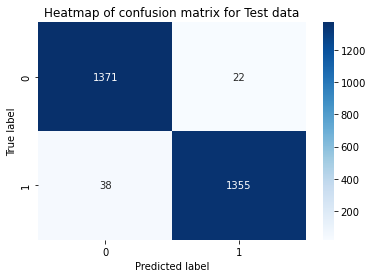

In [22]:
param_grid = {'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]}

svm_pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', svm.SVC(max_iter=-1, random_state=123)),
])

svm_model_cv_2 = GridSearchCV(svm_pipe_tfidf, cv=2, param_grid=param_grid, scoring='f1')
svm_model_cv_2.fit(X_train, y_train)

print('Best ngram_range:', svm_model_cv_2.best_estimator_.get_params()['tfidf__ngram_range'])

predictions = svm_model_cv_2.predict(X_test)
evaluate(y_test, predictions )

In [23]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9730    0.9842    0.9786      1393
         1.0     0.9840    0.9727    0.9783      1393

    accuracy                         0.9785      2786
   macro avg     0.9785    0.9785    0.9785      2786
weighted avg     0.9785    0.9785    0.9785      2786



#### **Evaluation** using **Logistic Regression** model with **hyperparameter tuning** (using **GridSearchCV**)

Best l1_ratio: none
Best C: 30
Best penalty: l2
Best solver: saga


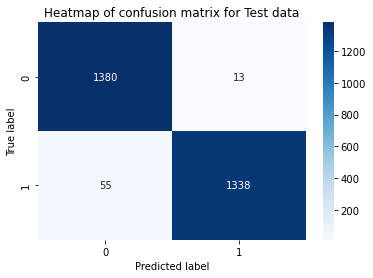

In [24]:
grid = {"lr__C":[1, 10, 20, 30, 40], 'lr__l1_ratio':['none', 0, 0.1], 'lr__penalty':['l2', 'elasticnet'],
       'lr__solver':['lbfgs', 'saga']}

# Pipeline for TfidfVectorizer - with the best ngram_range - and Logistic Regression Classifier 
lr_pipe_tfidf_2 = Pipeline([
 ('tfidf', TfidfVectorizer(ngram_range = (1,2))),
 ('lr', LogisticRegression(max_iter=1500, n_jobs = -1, random_state=42))
])

logreg_cv_3=GridSearchCV(lr_pipe_tfidf_2, grid, scoring='f1', cv=2)
logreg_cv_3.fit(X_train, y_train)

print('Best l1_ratio:', logreg_cv_3.best_estimator_.get_params()['lr__l1_ratio'])
print('Best C:', logreg_cv_3.best_estimator_.get_params()['lr__C'])
print('Best penalty:', logreg_cv_3.best_estimator_.get_params()['lr__penalty'])
print('Best solver:', logreg_cv_3.best_estimator_.get_params()['lr__solver'])

predictions = logreg_cv_3.predict(X_test)
evaluate(y_test, predictions )


In [25]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9617    0.9907    0.9760      1393
         1.0     0.9904    0.9605    0.9752      1393

    accuracy                         0.9756      2786
   macro avg     0.9760    0.9756    0.9756      2786
weighted avg     0.9760    0.9756    0.9756      2786



#### **Evaluation** using **SVM** model with **hyperparameter tuning** (using **GridSearchCV**)

Best KERNEL: rbf
Best C: 1.5


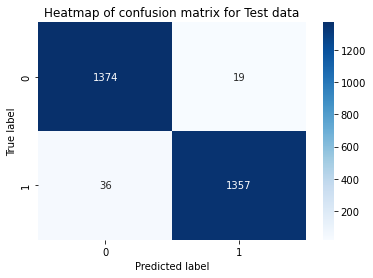

In [26]:
param_grid_svm = [
    {'svm__kernel':('linear', 'rbf')},
    {'svm__C':[0.5, 1, 1.5, 1.9]},
]    

# Pipeline for TfidfVectorizer - with the best ngram_range - and SVM Classifier 

svm_pipe_tfidf_2 = Pipeline([
 ('tfidf', TfidfVectorizer(ngram_range = (1,1))),
 ('svm',svm.SVC(random_state=123))
])

svm_model_cv_3 = GridSearchCV(svm_pipe_tfidf_2, param_grid_svm, cv=2)

svm_model_cv_3.fit(X_train, y_train)

print('Best KERNEL:', svm_model_cv_3.best_estimator_.get_params()['svm__kernel'])
print('Best C:', svm_model_cv_3.best_estimator_.get_params()['svm__C'])

predictions = svm_model_cv_3.predict(X_test)
evaluate(y_test, predictions )

In [27]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9745    0.9864    0.9804      1393
         1.0     0.9862    0.9742    0.9801      1393

    accuracy                         0.9803      2786
   macro avg     0.9803    0.9803    0.9803      2786
weighted avg     0.9803    0.9803    0.9803      2786



### Word2Vec Model

In [28]:
train_cleaned_reviews = X_train.str.split() # tokenization
test_cleaned_reviews = X_test.str.split() # tokenization

#### **Although our dataset is not very large**, we will use **Word2Vec without using pretrained word embeddings** because we think we **have enough data to go for a custom vectorization** as it **will be very specific to the context the corpus has**.

#### Word2Vec model with **default parameters** except for the number of features (500)

In [29]:

number_of_features = 500
model_w2v = Word2Vec(
            train_cleaned_reviews,
            size=number_of_features, # nmumber of features
            window=5, # window size
            min_count=5, # Ignores all words with total frequency lower than 5.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0, # negative sampling will be used
            negative = 10, # > 0, for negative sampling
            workers= 4, # number of cores
            seed = 42 
) 

model_w2v.train(train_cleaned_reviews, total_examples= len(X_train), epochs=20)

(5047666, 5926340)

#### UDF to **get the vectors** that will **feed** the **classifiers**

In [30]:
def getVectors(dataset):
  word_Embedding=np.zeros(number_of_features) 
  vectors=[]
  for review in dataset:
    wordCount=0
    # Loop over each word in the review and, if it is in the model's vocaublary, add its feature vector to the total
    for word in review: 
      if word in model_w2v.wv.vocab: # model_w2v.wv.vocab is a list that contains the names of the words in the model's vocabulary
        word_Embedding=word_Embedding+model_w2v.wv[word] 
        wordCount=wordCount+1
  
    word_Embedding=word_Embedding/wordCount  # Get the average
    vectors.append(word_Embedding)
  return vectors

trainReviewVectors=getVectors(train_cleaned_reviews)
testReviewVectors=getVectors(test_cleaned_reviews)

#### Establishing **benchmarks** with two **classifiers** with the **default hyperparameters**

#### **Evaluation** using **Logistic Regression** with the **default hyperparameters**

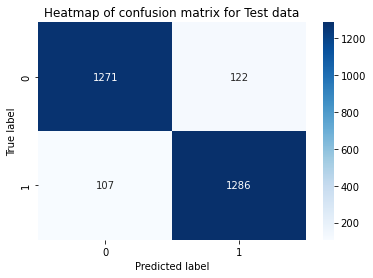

In [31]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(trainReviewVectors, y_train)
predictions = model_lr.predict(testReviewVectors)
evaluate(y_test, predictions)

In [32]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9224    0.9124    0.9174      1393
         1.0     0.9134    0.9232    0.9182      1393

    accuracy                         0.9178      2786
   macro avg     0.9179    0.9178    0.9178      2786
weighted avg     0.9179    0.9178    0.9178      2786



#### **Evaluation** using **SVM** with the **default hyperparameters**

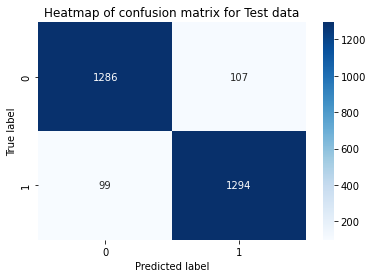

In [33]:
model_svm = svm.SVC(random_state=42)
model_svm.fit(trainReviewVectors, y_train)
predictions = model_svm.predict(testReviewVectors)
evaluate(y_test, predictions)

In [34]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9285    0.9232    0.9258      1393
         1.0     0.9236    0.9289    0.9263      1393

    accuracy                         0.9261      2786
   macro avg     0.9261    0.9261    0.9261      2786
weighted avg     0.9261    0.9261    0.9261      2786



#### **Logistic Regression** with **Hyperparameter tuning** (using **GridSearchCV**)

Best C: 30
Best l1_ratio: none
Best penalty: l2
Best solver: lbfgs


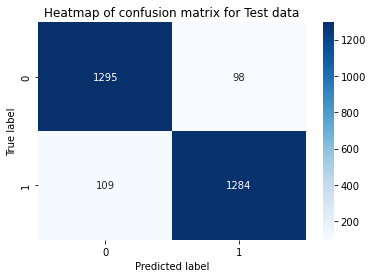

In [35]:
grid_lr_word2vec = {"C":[1, 10, 20, 30, 50], 'l1_ratio':['none', 0, 0.1], 'penalty':['l2', 'elasticnet'],
                'solver':['lbfgs', 'saga']}

lr_word2vec = LogisticRegression(max_iter=1500, random_state=42)

logreg_cv_word2vec=GridSearchCV(lr_word2vec, grid_lr_word2vec, n_jobs=-1)
logreg_cv_word2vec.fit(trainReviewVectors, y_train)

print('Best C:', logreg_cv_word2vec.best_estimator_.get_params()['C'])
print('Best l1_ratio:', logreg_cv_word2vec.best_estimator_.get_params()['l1_ratio'])
print('Best penalty:', logreg_cv_word2vec.best_estimator_.get_params()['penalty'])
print('Best solver:', logreg_cv_word2vec.best_estimator_.get_params()['solver'])


predictions = logreg_cv_word2vec.predict(testReviewVectors)
evaluate(y_test, predictions )

In [36]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9224    0.9296    0.9260      1393
         1.0     0.9291    0.9218    0.9254      1393

    accuracy                         0.9257      2786
   macro avg     0.9257    0.9257    0.9257      2786
weighted avg     0.9257    0.9257    0.9257      2786



#### **SVM** with **Hyperparameter tuning** (using **GridSearchCV**)

Best KERNEL: rbf
Best C: 30


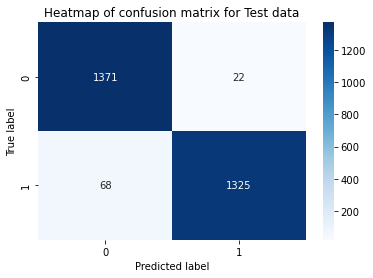

In [37]:
# Hyperparameter tuning with SVM 

grid_svm_word2vec = [
    {'kernel':('linear', 'rbf')},
    {'C':[1, 10, 20, 25, 30, 35]},
]    

svm_word2vec = svm.SVC(random_state=42)


svm_word2vec_cv = GridSearchCV(svm_word2vec, grid_svm_word2vec, n_jobs=-1)

svm_word2vec_cv.fit(trainReviewVectors, y_train)

print('Best KERNEL:', svm_word2vec_cv.best_estimator_.get_params()['kernel'])
print('Best C:', svm_word2vec_cv.best_estimator_.get_params()['C'])

predictions = svm_word2vec_cv.predict(testReviewVectors)
evaluate(y_test, predictions)

In [38]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9527    0.9842    0.9682      1393
         1.0     0.9837    0.9512    0.9672      1393

    accuracy                         0.9677      2786
   macro avg     0.9682    0.9677    0.9677      2786
weighted avg     0.9682    0.9677    0.9677      2786



### **Doc2Vec** model

#### To keep **features** and **labels** in only **two** datasets, let's concatenate X_train and y_train into a **train set**, and X_test and y_test into a **test set**.

In [39]:
train = pd.concat([X_train, y_train], axis=1)
train = train.reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1)
test = test.reset_index(drop=True)
train.shape

(6500, 2)

In [40]:
train.head()

,cleaned_reviews,sentiment
0,journeyman want like try hard consider restaur...,0.0
1,sad old chef leave start come delicious menu c...,0.0
2,come familiar expect parent surprised generous...,1.0
3,aldo server excellent attentive point come cel...,1.0
4,good chinese town order time count hand sesame...,1.0


In [41]:
train.columns

Index(['cleaned_reviews', 'sentiment'], dtype='object')

In [42]:
train_tagged =  [TaggedDocument((train['cleaned_reviews'].str.split(' ')[i]), [train['sentiment'].loc[i]]) for i in range(len(train))]
test_tagged =  [TaggedDocument((test['cleaned_reviews'].str.split(' ')[i]), [test['sentiment'].loc[i]]) for i in range(len(test))]

In [43]:
train_tagged[0] # example with the first review of the train set

TaggedDocument(words=['journeyman', 'want', 'like', 'try', 'hard', 'consider', 'restaurant', 'literally', 'minute', 'house', 'neighbor', 'love', 'union', 'square', 'refinement', 'journeyman', 'purportedly', 'bring', 'definitely', 'overdue', 'work', 'paper', 'restaurant', 'love', 'local', 'modern', 'inventive', 'casual', 'reality', 'restaurant', 'seriously', 'despite', 'disappointing', 'dining', 'experience', 'glad', 'return', 'hub', 'celebrate', 'wedding', 'anniversary', 'opt', 'course', 'omnivore', 'menu', 'add', 'serving', 'foie', 'gra', 'confit', 'veal', 'tongue', 'smoke', 'beef', 'heart', 'course', 'menu', 'consist', 'spring', 'salad', 'favas', 'pea', 'spinach', 'carrot', 'spring', 'foam', 'serve', 'purpose', 'asparagus', 'soy', 'bonito', 'sous', 'vide', 'black', 'cod', 'leek', 'puree', 'potato', 'veal', 'breast', 'sweetbread', 'artichoke', 'dessert', 'cane', 'sugar', 'include', 'macaron', 'shoofly', 'pie', 'different', 'thing', 'amuse', 'offer', 'warm', 'lentil', 'salad', 'gruyere

#### Doc2Vec model using **negative smapling** with **default hyperparameters** except for the number of features (500) given the **vast corpus** 

In [44]:
model_dbow = Doc2Vec(dm=1, vector_size=500, workers=4, hs=0, negative=5, seed=123)
model_dbow.build_vocab(train_tagged)

In [45]:
model_dbow.train(train_tagged, total_examples=len(train_tagged), epochs=10)

#### Building the **Final Vector Feature** for the classifiers


In [46]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(list(doc.words))) for doc in sents])
    return targets, regressors

In [47]:
y_train_tagged, X_train_tagged = vec_for_learning(model_dbow, train_tagged)
y_test_tagged, X_test_tagged = vec_for_learning(model_dbow, test_tagged)

#### Using the **Logistic Regression** model with the the **default hyperparameters**

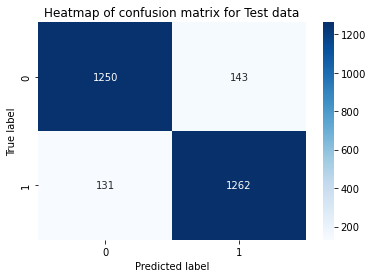

In [48]:
model_lr = LogisticRegression(max_iter=100, random_state=123)
model_lr.fit(X_train_tagged, y_train_tagged)
predictions = model_lr.predict(X_test_tagged)
evaluate(y_test_tagged, predictions )

In [49]:
print(classification_report(y_test_tagged, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9051    0.8973    0.9012      1393
         1.0     0.8982    0.9060    0.9021      1393

    accuracy                         0.9017      2786
   macro avg     0.9017    0.9017    0.9016      2786
weighted avg     0.9017    0.9017    0.9016      2786



#### Using **SVM** model with the the **default hyperparameters**

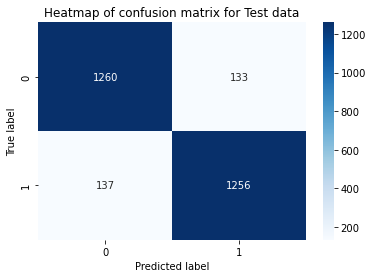

In [50]:
model_svm = svm.SVC(max_iter=-1, random_state=42) 
model_svm.fit(X_train_tagged, y_train_tagged)
predictions = model_svm.predict(X_test_tagged)
evaluate(y_test_tagged, predictions)

In [51]:
print(classification_report(y_test_tagged, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9019    0.9045    0.9032      1393
         1.0     0.9042    0.9017    0.9029      1393

    accuracy                         0.9031      2786
   macro avg     0.9031    0.9031    0.9031      2786
weighted avg     0.9031    0.9031    0.9031      2786



#### **Hyperparemeter tuning** (using **GridSearchCV**) for **Logistic Regression**

Best C: 1.7
Best l1_ratio: none
Best penalty l2
Best solver: lbfgs


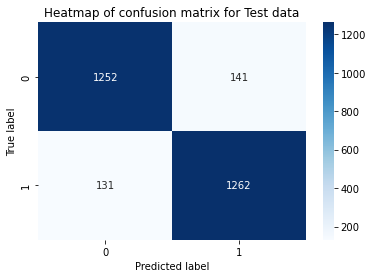

In [52]:
grid_doc2vec_lr = {"C":[1, 1.5, 1.7, 1.8], 'l1_ratio':['none', 0, 0.1], 'penalty':['l2', 'elasticnet'],
       'solver':['lbfgs', 'saga']}

model_lr = LogisticRegression(max_iter=100, random_state=123) 
logreg_cv_doc2vec=GridSearchCV(model_lr, grid_doc2vec_lr, cv=2, n_jobs=-1)
logreg_cv_doc2vec.fit(X_train_tagged, y_train_tagged)

print('Best C:', logreg_cv_doc2vec.best_estimator_.get_params()['C'])
print('Best l1_ratio:', logreg_cv_doc2vec.best_estimator_.get_params()['l1_ratio'])
print('Best penalty', logreg_cv_doc2vec.best_estimator_.get_params()['penalty'])
print('Best solver:', logreg_cv_doc2vec.best_estimator_.get_params()['solver'])


predictions = logreg_cv_doc2vec.predict(X_test_tagged)
evaluate(y_test_tagged, predictions)

In [53]:
print(classification_report(y_test_tagged, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9053    0.8988    0.9020      1393
         1.0     0.8995    0.9060    0.9027      1393

    accuracy                         0.9024      2786
   macro avg     0.9024    0.9024    0.9024      2786
weighted avg     0.9024    0.9024    0.9024      2786



#### **Hyperparameter tuning** (using **GridSearchCV**) for **SVM**

Best KERNEL: rbf
Best C: 8


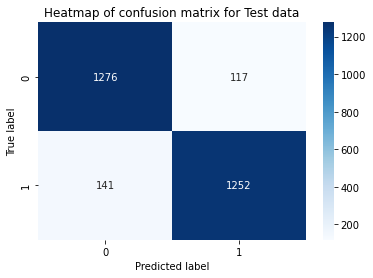

In [54]:
grid_doc2vec_svm = [
    {'kernel':('linear', 'rbf')},
    {'C':[ 1, 4, 8, 12, 16, 20]},
]    

svm_model = svm.SVC(random_state=42)


svm_model_cv_doc2vec = GridSearchCV(svm_model, grid_doc2vec_svm, n_jobs=-1)

svm_model_cv_doc2vec.fit(X_train_tagged, y_train_tagged)

print('Best KERNEL:', svm_model_cv_doc2vec.best_estimator_.get_params()['kernel'])
print('Best C:', svm_model_cv_doc2vec.best_estimator_.get_params()['C'])

predictions = svm_model_cv_doc2vec.predict(X_test_tagged)
evaluate(y_test_tagged, predictions)

In [55]:
print(classification_report(y_test_tagged, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9005    0.9160    0.9082      1393
         1.0     0.9145    0.8988    0.9066      1393

    accuracy                         0.9074      2786
   macro avg     0.9075    0.9074    0.9074      2786
weighted avg     0.9075    0.9074    0.9074      2786



#### **Conclusions**: 
#### - For **all** models, **F1 scores** have **high values** (> 90%).
#### - **All tuned** models have **higher values** for **F1 score** than the **corresponding non-tuned** models, as **expected** (with the exception of Logistic Regression with CountVectorizer, we got the same score for the non-tuned model and for the tuned model) .
#### - The **best F1 scores** (for both labels) were achieved using **TF-IDF** with the **SVM** model with **hyperparameter tuning** (just above 98%). 